In [1]:
#https://online.stat.psu.edu/stat510/
#https://otexts.com/fpp2/advanced.html


     ---------------------------------------- 0.0/9.2 MB ? eta -:--:--
     ---------------------------------------- 0.0/9.2 MB ? eta -:--:--
     ---------------------------------------- 0.0/9.2 MB 330.3 kB/s eta 0:00:28
     - -------------------------------------- 0.3/9.2 MB 2.2 MB/s eta 0:00:05
     ------------ --------------------------- 2.9/9.2 MB 16.7 MB/s eta 0:00:01
     ------------------------ --------------- 5.7/9.2 MB 24.1 MB/s eta 0:00:01
     ------------------------------------- -- 8.7/9.2 MB 30.8 MB/s eta 0:00:01
     ---------------------------------------- 9.2/9.2 MB 29.4 MB/s eta 0:00:00
     ---------------------------------------- 0.0/233.8 kB ? eta -:--:--
     ------------------------------------- 233.8/233.8 kB 14.0 MB/s eta 0:00:00


In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima.model import ARIMA

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_predict


from sklearn.linear_model import LinearRegression

# 0/ Preprocessing

In [2]:
def download_stock_data(ticker_symbol):
    url = f"https://query1.finance.yahoo.com/v7/finance/download/{ticker_symbol}?period1=0&period2=9999999999&interval=1d&events=history"
    df = pd.read_csv(url)
    return df

ticker_symbol =  "^GSPC"
df = download_stock_data(ticker_symbol)

In [3]:
df = df[['Date', 'Open']]

df["Date"] = pd.to_datetime(df["Date"])
df['Year'] = pd.DatetimeIndex(df['Date']).year
df['Month'] = pd.DatetimeIndex(df['Date']).month

df = df[df['Year']>1983].reset_index(drop=True)
df = df.set_index('Date')

print(df.shape)
print(df.columns)

(10041, 3)
Index(['Open', 'Year', 'Month'], dtype='object')


In [4]:
df = df['Open'].resample('MS').mean()

# 1/ Premiers plots

<Axes: xlabel='Date'>

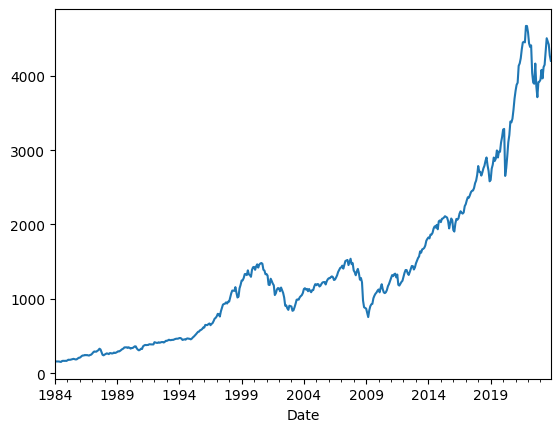

In [5]:
df.plot()

In [6]:
df = df.to_frame(name='Open')

## a) Full

In [7]:
'''
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2)

seasonal_decompose(df[:37], model='additive').plot().savefig('temp_fig1.png'), plt.close()
seasonal_decompose(df, model='additive').plot().savefig('temp_fig2.png'), plt.close()

ax1.imshow(plt.imread('temp_fig1.png'))
ax2.imshow(plt.imread('temp_fig2.png'))

ax1.axis('off'), ax2.axis('off'), os.remove('temp_fig1.png'), os.remove('temp_fig2.png')
plt.subplots_adjust(left=-0.1, bottom=-1.5, right=2, top=0.1, wspace=0.25, hspace=0.5)
''';

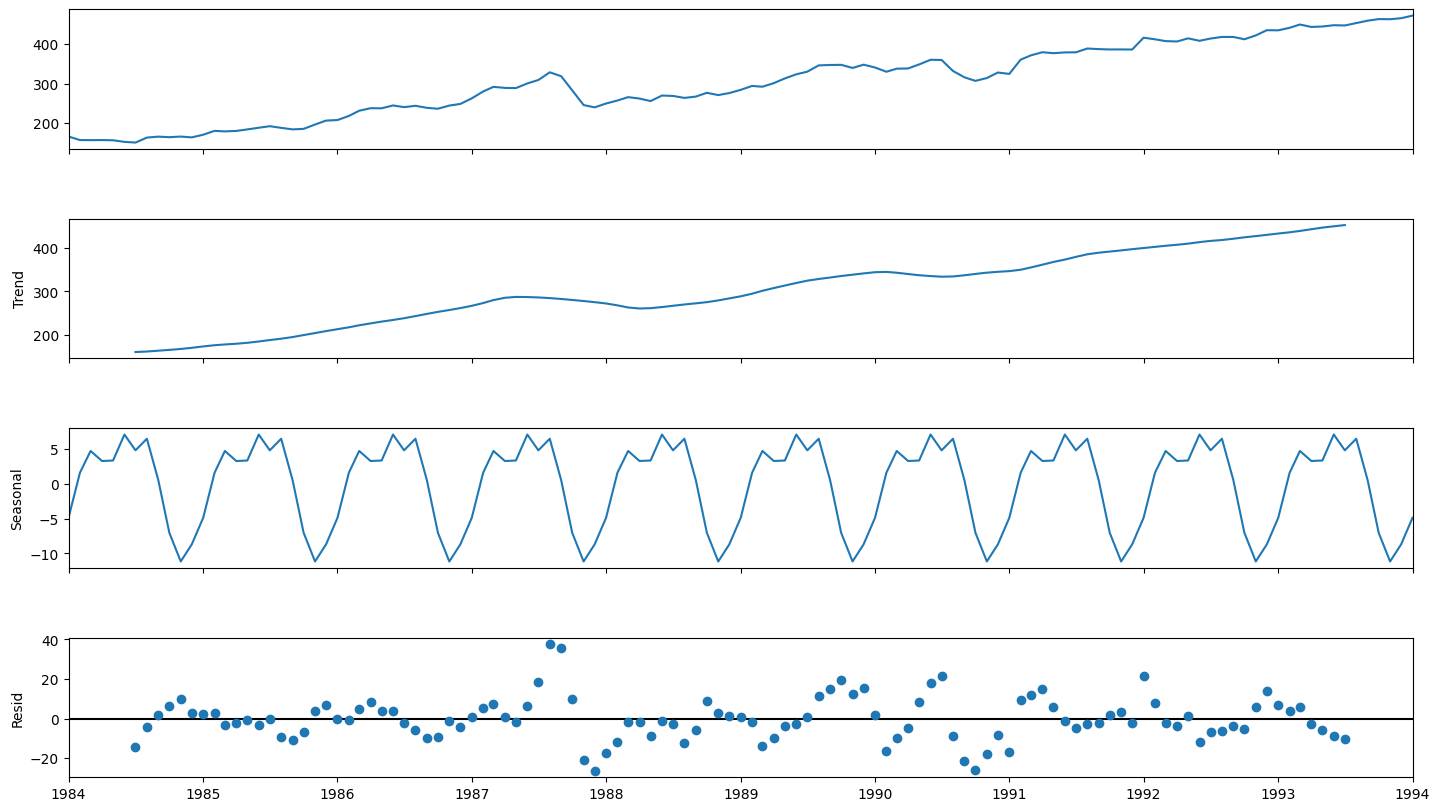

In [8]:
seasonal_decompose(df[:121], model='additive').plot()
plt.subplots_adjust(left=-0.1, bottom=-1.5, right=2, top=0.1, wspace=0.25, hspace=0.5)

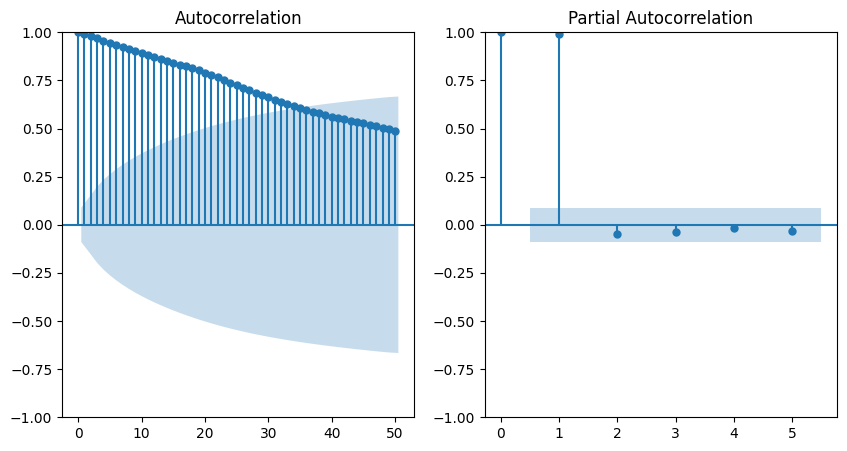

In [9]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
plot_acf(df, lags=50, ax=ax[0])
plot_pacf(df, lags=5, ax=ax[1])
plt.show()

## b) Diff

In [10]:
dy = df['Open'].diff().diff().dropna()

In [11]:
adfuller(dy)

(-9.340517384390276,
 8.822680777404789e-16,
 16,
 460,
 {'1%': -3.44464601455782,
  '5%': -2.867843681679954,
  '10%': -2.570127622873346},
 5145.223841446339)

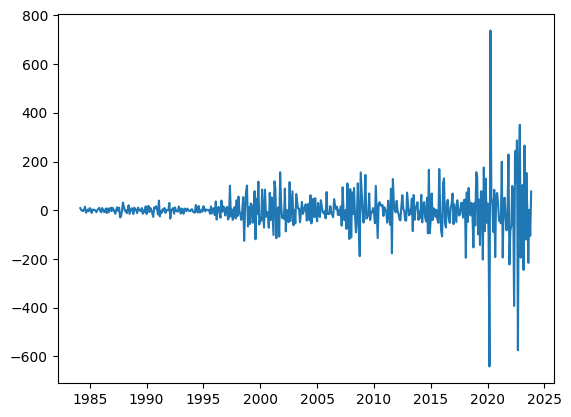

In [12]:
plt.plot(dy)
#seasonal_decompose(dy[:121], model='additive').plot()
#plt.subplots_adjust(left=-0.1, bottom=-1.5, right=2, top=0.1, wspace=0.25, hspace=0.5)

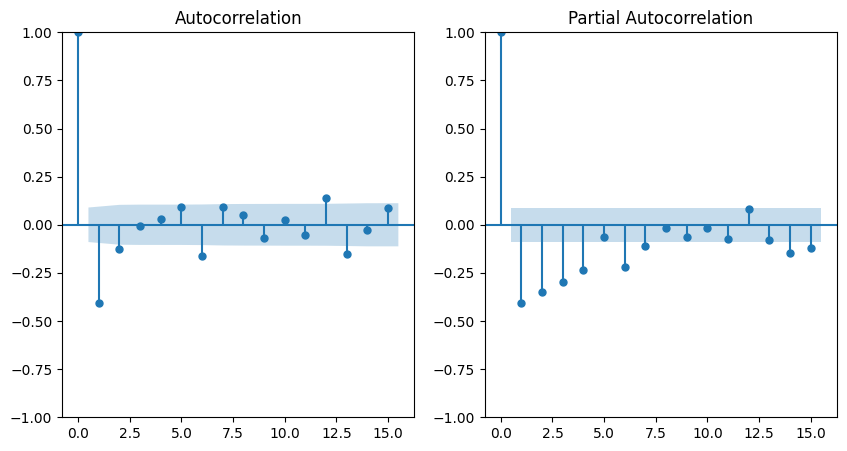

In [13]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
plot_acf(dy, lags=15, ax=ax[0])
plot_pacf(dy, lags=15, ax=ax[1])
plt.show()

## c) Variation

In [14]:
dlog_y = np.log(df['Open']).diff().dropna()

In [15]:
adfuller(dlog_y)

(-14.617979757181832,
 3.926236849020997e-27,
 1,
 476,
 {'1%': -3.444162847239118,
  '5%': -2.8676311169658177,
  '10%': -2.5700143303792107},
 -1754.5977379939131)

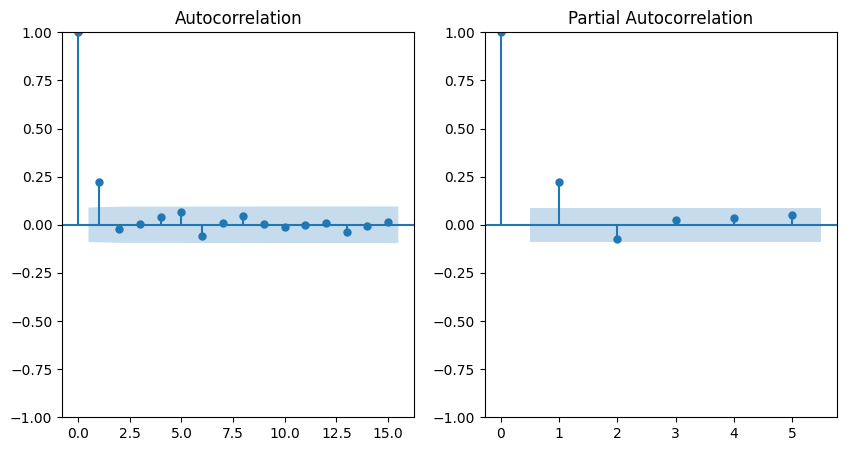

In [16]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
plot_acf(dlog_y, lags=15, ax=ax[0])
plot_pacf(dlog_y, lags=5, ax=ax[1])
plt.show()

# 2/ Prédictions

## a) ar(1)

In [17]:
df['Lag'] = df['Open'].shift(1)
X = df[['Lag']].iloc[1:].to_numpy()
y = df['Open'].iloc[1:].to_numpy()

In [18]:
reg = LinearRegression().fit(X,y)
print(reg.intercept_, reg.coef_, reg.score(X, y))

2.9940969851634236 [1.00397509] 0.9966206797395296


In [19]:
df['AR(1)'] = reg.predict(df[['Open']].to_numpy())

TypeError: 'numpy.float64' object is not iterable

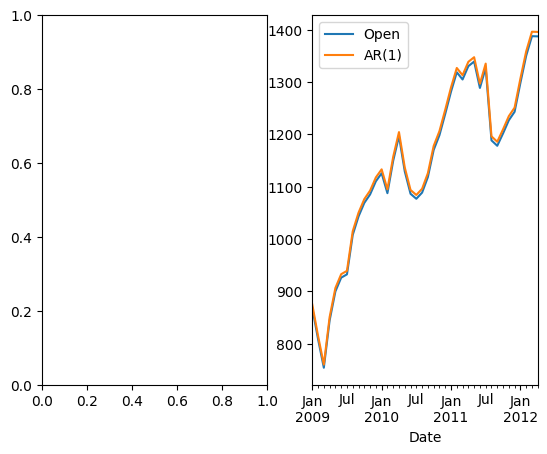

In [20]:
fig, (ax1, ax0) = plt.subplots(nrows=1,ncols=2)

s, e = 300, 340
df_ = df[['Open', 'AR(1)']].iloc[s:e]
df_.plot(ax=ax0)
plt.xlim(df_.index[0], df_.index[-1])
plt.ylim(min(np.min(df_)), max(np.max(df_)))

y = df['Open']
a,b = reg.intercept_, reg.coef_
ax1.scatter(df['Lag'], y, s=1)
ax1.plot(df['Lag'], a+b*df['Lag'], 'r', linewidth=1)

plt.subplots_adjust(left=-1, bottom=-1, right=2, top=0.1, wspace=0.25, hspace=0.5)

## b) Arima

In [ ]:
model = ARIMA(df['Open'][:-60], order=(4, 2, 1), seasonal_order=(0,0,0,12)).fit()
print(model.summary())
model.plot_diagnostics(figsize=(16, 8))
plt.show()

In [ ]:
fig, ax = plt.subplots(1,2)

ax[0] = df['Open'][:300].plot(ax=ax[0])
figure = plot_predict(model,start = '1990', end = '2008', ax = ax[0], dynamic = True);
ax[0].set_ylim(150,1400)

ax[1] = df['Open'][:300].plot(ax=ax[1])
figure = plot_predict(model,start = '1990', end = '2008', ax = ax[1], dynamic = False);
ax[1].set_ylim(150,1400)


plt.subplots_adjust(left=-0.1, bottom=-1, right=2, top=0.1, wspace=0.25, hspace=0.5)

In [ ]:
model.forecast(60).plot(color='blue')
df['Open'][-60:].plot(color='green')
plt.plot();